In [1]:
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,DataCollatorWithPadding
import nltk
from datasets import Dataset
import numpy as np 
import pandas as pd
import polars as pl
import re
import random
import matplotlib.pyplot as plt
import warnings
import gc
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, cohen_kappa_score
from lightgbm import log_evaluation, early_stopping
import pickle
from scipy.special import softmax
import wandb

wandb.init(mode='disabled')
warnings.filterwarnings('ignore')
nltk.download('wordnet')

2024-05-21 10:10:38.894654: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 10:10:38.894745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 10:10:39.005480: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
columns = [  
    (
        pl.col("full_text").str.split(by="\n\n").alias("paragraph")
    ),
]
PATH = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/"
train = pl.read_csv(PATH + "train.csv").with_columns(columns)
test = pl.read_csv(PATH + "test.csv").with_columns(columns)

train.head(1)

essay_id,full_text,score,paragraph
str,str,i64,list[str]
"""000d118""","""Many people ha…",3,"[""Many people have car where they live. The thing they don't know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban's families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the French and Swiss borders. You probaly won't see a car in Vauban's streets because they are completely ""car free"" but If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growing trend in Europe,The untile states and some where else are suburban life from auto use this is called ""smart planning"". The current efforts to drastically reduce greenhouse gas emissions from tailes the passengee cars are responsible for 12 percent of greenhouse gas emissions in Europe and up to 50 percent in some car intensive in the United States. I honeslty think that good idea that they did that is Vaudan because that makes cities denser and better for walking and in VAUBAN there are 5,500 residents within a rectangular square mile. In the artical David Gold berg said that ""All of our development since World war 2 has been centered on the cars,and that will have to change"" and i think that was very true what David Gold said because alot thing we need cars to do we can go anyway were with out cars beacuse some people are a very lazy to walk to place thats why they alot of people use car and i think that it was a good idea that that they did that in VAUBAN so people can see how we really don't need car to go to place from place because we can walk from were we need to go or we can ride bycles with out the use of a car. It good that they are doing that if you thik about your help the earth in way and thats a very good thing to. In the United states ,the Environmental protection Agency is promoting what is called ""car reduced""communtunties,and the legislators are starting to act,if cautiously. Maany experts expect pubic transport serving suburbs to play a much larger role in a new six years federal transportation bill to approved this year. In previous bill,80 percent of appropriations have by law gone to highways and only 20 percent to other transports. There many good reason why they should do this. ""]"


In [3]:
cList = {
  "ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because",  "could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not",
  "haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he'll've": "he will have","he's": "he is",
  "how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how is","I'd": "I would","I'd've": "I would have","I'll": "I will","I'll've": "I will have","I'm": "I am","I've": "I have",
  "isn't": "is not","it'd": "it had","it'd've": "it would have","it'll": "it will", "it'll've": "it will have","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not",
  "might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have","needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
  "shan't've": "shall not have","she'd": "she would","she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is",
  "should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have","so's": "so is","that'd": "that would","that'd've": "that would have","that's": "that is","there'd": "there had","there'd've": "there would have","there's": "there is","they'd": "they would","they'd've": "they would have","they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we had",
  "we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have",
  "weren't": "were not","what'll": "what will","what'll've": "what will have",
  "what're": "what are","what's": "what is","what've": "what have","when's": "when is","when've": "when have",
  "where'd": "where did","where's": "where is","where've": "where have","who'll": "who will","who'll've": "who will have","who's": "who is","who've": "who have","why's": "why is",
  "why've": "why have","will've": "will have","won't": "will not","won't've": "will not have","would've": "would have","wouldn't": "would not",
  "wouldn't've": "would not have","y'all": "you all","y'alls": "you alls","y'all'd": "you all would",
  "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you had","you'd've": "you would have","you'll": "you you will","you'll've": "you you will have","you're": "you are",  "you've": "you have"
   }

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)
def dataPreprocessing(x):
    x = x.lower()
    x = removeHTML(x)
    x = re.sub("@\w+", '',x)
    x = re.sub("'\d+", '',x)
    x = re.sub("\d+", '',x)
    x = re.sub("http\w+", '',x)
    x = re.sub(r"\s+", " ", x)
    x = re.sub(r"\.+", ".", x)
    x = re.sub(r"\,+", ",", x)
    x = x.strip()
    return x

In [4]:
def Paragraph_Preprocess(tmp):
    tmp = tmp.explode('paragraph')
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(dataPreprocessing))
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x)).alias("paragraph_len"))
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x.split('.'))).alias("paragraph_sentence_cnt"),
                    pl.col('paragraph').map_elements(lambda x: len(x.split(' '))).alias("paragraph_word_cnt"),)
    return tmp
paragraph_fea = ['paragraph_len','paragraph_sentence_cnt','paragraph_word_cnt']

def Paragraph_Eng(train_tmp):
    aggs = [
        *[pl.col('paragraph').filter(pl.col('paragraph_len') >= i).count().alias(f"paragraph_{i}_cnt") for i in [50,75,100,125,150,175,200,250,300,350,400,500,600,700] ], 
        *[pl.col('paragraph').filter(pl.col('paragraph_len') <= i).count().alias(f"paragraph_{i}_cnt") for i in [25,49]], 
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in paragraph_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in paragraph_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in paragraph_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in paragraph_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in paragraph_fea],
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df


tmp = Paragraph_Preprocess(train)
train_feats = Paragraph_Eng(tmp)
train_feats['score'] = train['score']
feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

Features Number:  31


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,paragraph_len_min,paragraph_sentence_cnt_min,paragraph_word_cnt_min,paragraph_len_first,paragraph_sentence_cnt_first,paragraph_word_cnt_first,paragraph_len_last,paragraph_sentence_cnt_last,paragraph_word_cnt_last,score
0,000d118,1,1,1,1,1,1,1,1,1,...,2640,14,491,2640,14,491,2640,14,491,3
1,000fe60,5,5,5,5,5,5,4,3,3,...,184,3,37,184,4,37,235,3,46,3
2,001ab80,4,4,4,4,4,4,4,4,4,...,476,5,85,576,5,101,476,5,85,4


In [5]:
def Sentence_Preprocess(tmp):
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=".").alias("sentence"))
    tmp = tmp.explode('sentence')
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x)).alias("sentence_len"))
    tmp = tmp.filter(pl.col('sentence_len')>=15)
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x.split(' '))).alias("sentence_word_cnt"))
    
    return tmp

sentence_fea = ['sentence_len','sentence_word_cnt']

def Sentence_Eng(train_tmp):
    aggs = [
        *[pl.col('sentence').filter(pl.col('sentence_len') >= i).count().alias(f"sentence_{i}_cnt") for i in [15,50,100,150,200,250,300] ], 
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in sentence_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in sentence_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in sentence_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in sentence_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in sentence_fea],
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df

tmp = Sentence_Preprocess(train)
train_feats = train_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

Features Number:  48


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,sentence_len_max,sentence_word_cnt_max,sentence_len_mean,sentence_word_cnt_mean,sentence_len_min,sentence_word_cnt_min,sentence_len_first,sentence_word_cnt_first,sentence_len_last,sentence_word_cnt_last
0,000d118,1,1,1,1,1,1,1,1,1,...,593,127,202.076923,38.692308,36,7,36,7,47,10
1,000fe60,5,5,5,5,5,5,4,3,3,...,250,49,96.823529,20.470588,27,7,62,13,124,25
2,001ab80,4,4,4,4,4,4,4,4,4,...,237,47,126.708333,23.875000,58,10,144,27,58,10


In [6]:
def Word_Preprocess(tmp):
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=" ").alias("word"))
    tmp = tmp.explode('word')
    tmp = tmp.with_columns(pl.col('word').map_elements(lambda x: len(x)).alias("word_len"))
    tmp = tmp.filter(pl.col('word_len')!=0)
    
    return tmp

def Word_Eng(train_tmp):
    aggs = [
        *[pl.col('word').filter(pl.col('word_len') >= i+1).count().alias(f"word_{i+1}_cnt") for i in range(15) ], 
        pl.col('word_len').max().alias(f"word_len_max"),
        pl.col('word_len').mean().alias(f"word_len_mean"),
        pl.col('word_len').std().alias(f"word_len_std"),
        pl.col('word_len').quantile(0.25).alias(f"word_len_q1"),
        pl.col('word_len').quantile(0.50).alias(f"word_len_q2"),
        pl.col('word_len').quantile(0.75).alias(f"word_len_q3"),
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df

tmp = Word_Preprocess(train)
train_feats = train_feats.merge(Word_Eng(tmp), on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

Features Number:  69


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,word_12_cnt,word_13_cnt,word_14_cnt,word_15_cnt,word_len_max,word_len_mean,word_len_std,word_len_q1,word_len_q2,word_len_q3
0,000d118,1,1,1,1,1,1,1,1,1,...,6,6,5,2,25,4.378819,2.538495,3.0,4.0,5.0
1,000fe60,5,5,5,5,5,5,4,3,3,...,0,0,0,0,11,4.012048,2.060968,2.0,4.0,5.0
2,001ab80,4,4,4,4,4,4,4,4,4,...,14,10,5,2,15,4.574545,2.604621,3.0,4.0,5.0


In [7]:
vectorizer = TfidfVectorizer(
            tokenizer=lambda x: x,
            preprocessor=lambda x: x,
            token_pattern=None,
            strip_accents='unicode',
            analyzer = 'word',
            ngram_range=(4,8),
            min_df=0.05,
            max_df=0.95,
            sublinear_tf=True,
)
train_tfid = vectorizer.fit_transform([i for i in train['full_text']])
dense_matrix = train_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = train_feats['essay_id']
train_feats = train_feats.merge(df, on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

Features Number:  24394


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,tfid_24315,tfid_24316,tfid_24317,tfid_24318,tfid_24319,tfid_24320,tfid_24321,tfid_24322,tfid_24323,tfid_24324
0,000d118,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,000fe60,5,5,5,5,5,5,4,3,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,001ab80,4,4,4,4,4,4,4,4,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
vectorizer_cnt = CountVectorizer(
            tokenizer=lambda x: x,
            preprocessor=lambda x: x,
            token_pattern=None,
            strip_accents='unicode',
            analyzer = 'word',
            ngram_range=(3,5),
            min_df=0.10,
            max_df=0.85,
)
train_tfid = vectorizer_cnt.fit_transform([i for i in train['full_text']])
dense_matrix = train_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_cnt_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = train_feats['essay_id']
train_feats = train_feats.merge(df, on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

Features Number:  31753


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,tfid_cnt_7349,tfid_cnt_7350,tfid_cnt_7351,tfid_cnt_7352,tfid_cnt_7353,tfid_cnt_7354,tfid_cnt_7355,tfid_cnt_7356,tfid_cnt_7357,tfid_cnt_7358
0,000d118,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,000fe60,5,5,5,5,5,5,4,3,3,...,0,0,0,0,0,1,1,1,0,0
2,001ab80,4,4,4,4,4,4,4,4,4,...,0,0,2,2,2,0,0,0,0,0


In [9]:
def quadratic_weighted_kappa(y_true, y_pred):
    y_true = y_true + a
    y_pred = (y_pred + a).clip(1, 6).round()
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    return 'QWK', qwk, True

def qwk_obj(y_true, y_pred):
    labels = y_true + a
    preds = y_pred + a
    preds = preds.clip(1, 6)
    f = 1/2*np.sum((preds-labels)**2)
    g = 1/2*np.sum((preds-a)**2+b)
    df = preds - labels
    dg = preds - a
    grad = (df/g - f*dg/g**2)*len(labels)
    hess = np.ones(len(labels))
    return grad, hess

a = 2.948
b = 1.092

In [10]:
X = train_feats[feature_names].astype(np.float32).values

y_split = train_feats['score'].astype(int).values
y = train_feats['score'].astype(np.float32).values-a
oof = train_feats['score'].astype(np.float32).values


[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.703626	valid's QWK: 0.69291
[50]	train's QWK: 0.749185	valid's QWK: 0.727253
[75]	train's QWK: 0.774883	valid's QWK: 0.745318
[100]	train's QWK: 0.792453	valid's QWK: 0.762763
[125]	train's QWK: 0.802209	valid's QWK: 0.774302
[150]	train's QWK: 0.809579	valid's QWK: 0.778147
[175]	train's QWK: 0.814934	valid's QWK: 0.780311
[200]	train's QWK: 0.820615	valid's QWK: 0.781534
[225]	train's QWK: 0.826019	valid's QWK: 0.785576
[250]	train's QWK: 0.831231	valid's QWK: 0.789668
[275]	train's QWK: 0.834857	valid's QWK: 0.791772
[300]	train's QWK: 0.8391	valid's QWK: 0.793807
[325]	train's QWK: 0.842482	valid's QWK: 0.794129
[350]	train's QWK: 0.846	valid's QWK: 0.795121
[375]	train's QWK: 0.849912	valid's QWK: 0.795893
[400]	train's QWK: 0.852425	valid's QWK: 0.795948
[425]	train's QWK: 0.855539	valid's QWK: 0.796545
[450]	train's QWK: 0.858219	valid's QWK: 0

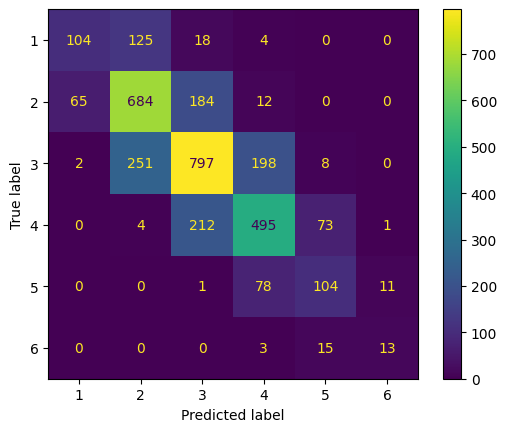

F1 score: 0.6321914236768369
Cohen kappa score: 0.8031961946307123


In [11]:
if_train = True

if if_train:
    callbacks = [log_evaluation(period=25), early_stopping(stopping_rounds=75,first_metric_only=True)]
    
    X_train, X_val, y_train, y_val, y_train_int, y_val_int = train_test_split(
        X, y, y_split, test_size=0.2, random_state=52, stratify=train_feats['score'])
    
    model = lgb.LGBMRegressor(
                    objective = qwk_obj,
                    metrics = 'None',
                    learning_rate = 0.05,
                    max_depth = 5,
                    num_leaves = 10,
                    colsample_bytree=0.3,
                    reg_alpha = 0.7,
                    reg_lambda = 0.1,
                    n_estimators=700,
                    random_state=42,
                    extra_trees=True,
                    class_weight='balanced',
                    verbosity = - 1)
    
    predictor = model.fit(X_train,
                          y_train,
                          eval_names=['train', 'valid'],
                          eval_set=[(X_train, y_train), (X_val, y_val)],
                          eval_metric=quadratic_weighted_kappa,
                          callbacks=callbacks,)
    
    predictions = predictor.predict(X_val)
    predictions = predictions + a
    predictions = predictions.clip(1, 6).round()
    f1 = f1_score(y_val_int, predictions, average='weighted')
    
    kappa = cohen_kappa_score(y_val_int, predictions, weights='quadratic')

    cm = confusion_matrix(y_val_int, predictions, labels=[x for x in range(1,7)])

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[x for x in range(1,7)])
    disp.plot()
    plt.show()
    print(f'F1 score: {f1}')
    print(f'Cohen kappa score: {kappa}')
    
    with open('lgbm_model.pkl', 'wb') as fp:
        pickle.dump(predictor, fp)

else:
    with open('/kaggle/input/lgbm-model/lgbm_model.pkl', 'rb') as f:
        predictor = pickle.load(f)

In [12]:
tmp = Paragraph_Preprocess(test)
test_feats = Paragraph_Eng(tmp)
# Sentence
tmp = Sentence_Preprocess(test)
test_feats = test_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')
# Word
tmp = Word_Preprocess(test)
test_feats = test_feats.merge(Word_Eng(tmp), on='essay_id', how='left')

# Tfidf
test_tfid = vectorizer.transform([i for i in test['full_text']])
dense_matrix = test_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = test_feats['essay_id']
test_feats = test_feats.merge(df, on='essay_id', how='left')

# CountVectorizer
test_tfid = vectorizer_cnt.transform([i for i in test['full_text']])
dense_matrix = test_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_cnt_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = test_feats['essay_id']
test_feats = test_feats.merge(df, on='essay_id', how='left')


# Features number
feature_names = list(filter(lambda x: x not in ['essay_id','score'], test_feats.columns))
print('Features number: ',len(feature_names))
test_feats.head(3)

Features number:  31753


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,tfid_cnt_7349,tfid_cnt_7350,tfid_cnt_7351,tfid_cnt_7352,tfid_cnt_7353,tfid_cnt_7354,tfid_cnt_7355,tfid_cnt_7356,tfid_cnt_7357,tfid_cnt_7358
0,000d118,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,000fe60,5,5,5,5,5,5,4,3,3,...,0,0,0,0,0,1,1,1,0,0
2,001ab80,4,4,4,4,4,4,4,4,4,...,0,0,2,2,2,0,0,0,0,0


In [13]:
feature_names = list(filter(lambda x: x not in ['essay_id','score'], test_feats.columns))

In [14]:
predictions_gb = predictor.predict(test_feats[feature_names])+ a
predictions_gb = np.round(predictions_gb.clip(1, 6))
predictions_gb

array([2., 3., 4.])

In [15]:
df = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv')
test_df = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv')

In [16]:
le = LabelEncoder()

df['score'] = le.fit_transform(df['score'])
df.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,2
1,000fe60,I am a scientist at NASA that is discussing th...,2
2,001ab80,People always wish they had the same technolog...,3
3,001bdc0,"We all heard about Venus, the planet without a...",3
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",2


In [17]:
df = df.set_index('essay_id').rename(columns={'score': 'label', 'full_text': 'text'})
test_df = test_df.set_index('essay_id').rename(columns={'full_text': 'text'})

In [18]:
train_split, val_split = train_test_split(df, test_size=0.2, random_state=52, stratify=df['label'])

In [19]:
from datasets import Dataset

dataset_train = Dataset.from_pandas(train_split)
dataset_val = Dataset.from_pandas(val_split)
dataset_test = Dataset.from_pandas(test_df)

In [20]:
if_train = True

if if_train:
    model_name = 'deepset/roberta-base-squad2-distilled'
else:
    model_name = '/kaggle/input/roberta-essay-scoring/roberta/checkpoint-2598'

In [21]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/295 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [22]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [23]:
tokenized_train = dataset_train.map(preprocess_function, batched=True)
tokenized_val = dataset_val.map(preprocess_function, batched=True)
tokenized_test = dataset_test.map(preprocess_function, batched=True)

Map:   0%|          | 0/13845 [00:00<?, ? examples/s]

Map:   0%|          | 0/3462 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [24]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [25]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    score = cohen_kappa_score(labels, predictions.argmax(-1), weights='quadratic')
    return { 'quadratic weighted kappa':score }

In [26]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(model_name, 
                                                           num_labels=6,
                                                           ignore_mismatched_sizes=True).to('cuda')

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at deepset/roberta-base-squad2-distilled and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
if_train = True
if if_train:
    training_args = TrainingArguments(
        output_dir="roberta",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        warmup_steps=500,
        load_best_model_at_end=True,
        evaluation_strategy="epoch",
        save_strategy="epoch"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()
else:
    args = TrainingArguments(
        ".", 
        per_device_eval_batch_size=16, 
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=args,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

Epoch,Training Loss,Validation Loss,Quadratic weighted kappa
1,1.191600,1.122631,0.647434
2,0.846800,1.043965,0.752716
3,0.619600,0.928165,0.791656


In [28]:
predictions_roberta = trainer.predict(tokenized_test)
predictions_roberta = predictions_roberta[0].argmax(axis=1).tolist()
predictions_roberta = le.inverse_transform(predictions_roberta)
predictions_roberta

array([2, 3, 5])

In [29]:
predictions_final = [predictions_gb, predictions_roberta]
predictions_final = np.mean(predictions_final, axis=0)
predictions_final = np.round(predictions_final.clip(1, 6))
predictions_final

array([2., 3., 4.])

In [30]:
submission = pd.read_csv("/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv")
submission['score'] = predictions_final
submission['score'] = submission['score'].astype(int)
submission.to_csv("submission.csv",index=None)
display(submission.head())

,essay_id,score
0,000d118,2
1,000fe60,3
2,001ab80,4
